### <center>A machine learning approach to classify cancer genes and  cancer-associated immune genes in a Next-generation RNA Seq</center>

#### Authors
* Lawrence Thanakumar Rajappa (**IDA, Linköping University, Linköping**)
* krzysztof Bartoszek (**STIMA,Linköping University, Linköping**)
* Jenny Persson (**Molecular Biology, Umeå University, Umeå**)

#### Abstract
<p align="justify">
In this study, we aim to predict the invasiveness of cancer subtypes by using a supervised and unsupervised machine learning approach. We will base on the next-generation RNA sequence data of cancer cells and cancer-associated immune cells to classify the cancerous cells from immune cells in the given samples taken from cancer patients and compare the classification/prediction performance of machine learning models such as SVM, decision tree, random forest, hierarchical clustering, etc. and choose the model that performs better. 

The evolution of genomic sequencing technology has led researchers to perform various experiments to find a cure for various genetic diseases such as cancer. The advent of Artificial Intelligence, especially in the healthcare sector has paved the way to numerous solutions such as drug discovery, cost-effective treatment for patients, etc. which would be beneficial for pharmaceutical organizations, hospitals, and researchers to perform their experiments at a fast pace. Further, Next-generation RNA sequencing data has helped to find the relationship between gene expression profiles and different developmental stages of a cell or a disease in an efficient and cost-effective approach with higher accuracy. There are various methodologies mentioned in various literature related to a cure for cancer, still, the fatality rate of cancer cannot be reduced. The machine learning approach helps us to understand the complexities and processes of cancer samples that lead to the development of effective cancer treatment/drugs in a reliable, fast, and efficient way.</p>


### Loading required libraries

In [193]:
%matplotlib inline
# Data loading and manipulation libraries
import pandas as pd
import numpy as np

# Visualization libraries
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from dtreeviz.trees import dtreeviz

# ML algorithms libraries
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier # Decision tree
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import f_classif
from sklearn import metrics
from numpy import set_printoptions
from sklearn.ensemble import RandomForestClassifier # Random Forest
from sklearn.svm import SVC # SVM
from sklearn.decomposition import PCA #PCA
from sklearn.model_selection import GridSearchCV 
from bioinfokit.visuz import cluster
from sklearn.metrics import precision_recall_fscore_support

### Loading the data

In [3]:
gene_data = pd.read_csv("../Data/12_Sample_Gene_List_Updated_with_labels.csv", index_col=False)

In [4]:
gene_data = gene_data.drop(["Unnamed: 0"], axis=1)

In [5]:
gene_data.sample(frac=1).head(6)

,Genes,hgnc_symbol,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,DR_UR,Type
474,ENSG00000226358,KRT8P38,315.868106,10.807661,0.868197,12.448402,1.426723e-35,4.057689e-34,UR,Cancer
397,ENSG00000104833,TUBB4A,261.799910,10.064602,0.854897,11.772882,5.385261e-32,1.274872e-30,UR,Cancer
6,ENSG00000104537,ANXA13,2.579087,-4.267433,1.128601,-3.781172,1.560920e-04,4.642305e-04,DR,Immune
337,ENSG00000251511,NaN,4.096568,4.911993,1.011374,4.856750,1.193282e-06,4.691360e-06,UR,Cancer
372,ENSG00000254275,LINC00824,1.798052,-3.725354,1.358412,-2.742433,6.098584e-03,1.370688e-02,DR,Cancer
234,ENSG00000158792,SPATA2L,2.718585,3.526107,1.241071,2.841180,4.494691e-03,1.041951e-02,UR,Immune


### Preprocessing of data

##### Checking for missing data

In [6]:
gene_data.isna().sum()

Genes               0
hgnc_symbol       124
baseMean            0
log2FoldChange      0
lfcSE               0
stat                0
pvalue              0
padj                0
DR_UR               0
Type                0
dtype: int64

**There is no reason to fill the missing gene symbols, as some genes will be a novel genes and do not have gene names. Moreover, this dimension won't be an important feature related to our target variable <mark>"Type"</mark>.**

#### Checking for linear separability (before outliers removal)

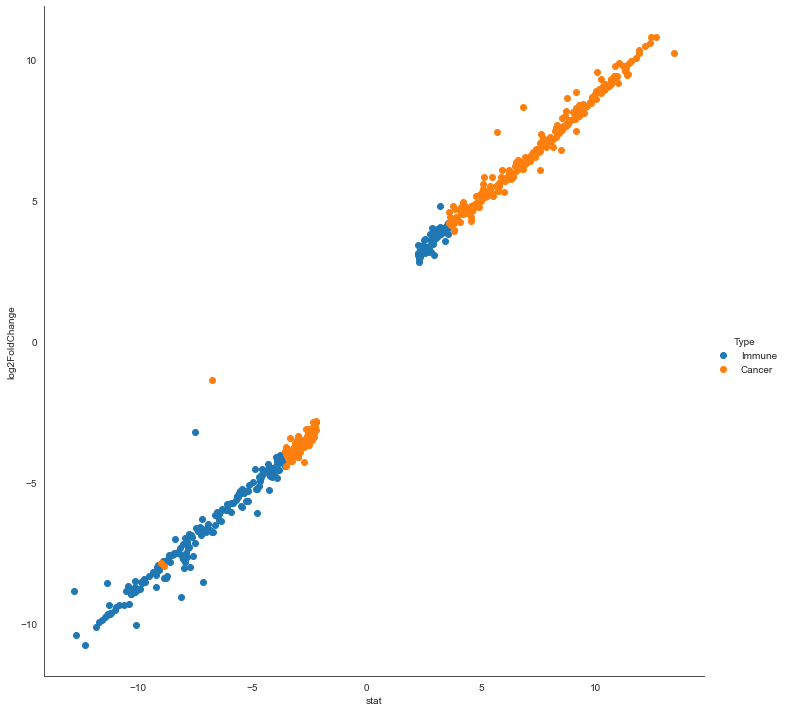

In [7]:
sns.set_style("white")
g = sns.FacetGrid(gene_data, hue="Type", height=10) \
   .map(plt.scatter, "stat", "log2FoldChange") \
   .add_legend() 
plt.show()

From the above graph, it could be seen that there is no linear separability is available. Hence we need to apply non-linear classification algorithms such as SVM Kernel, k-nearest-neighbors (kNN), Random Forest, and etc.

#### Checking for linear separability (after outliers removal)

##### List of outlier genes

In [8]:
outlier_genes = ["ENSG00000107159","ENSG00000119138","ENSG00000125676","ENSG00000254717","ENSG00000123096",
                 "ENSG00000110169","ENSG00000255386","ENSG00000134516","ENSG00000283051","ENSG00000204382",
                 "ENSG00000261997","ENSG00000269516","ENSG00000173391","ENSG00000172243","ENSG00000277120",
                 "ENSG00000169093"]

In [9]:
gene_data_outliers = gene_data[gene_data.Genes.isin(outlier_genes)]
gene_data_outliers.sort_values('log2FoldChange')

,Genes,hgnc_symbol,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,DR_UR,Type
200,ENSG00000261997,NaN,310.248612,-10.760381,0.872188,-12.337226,5.708900e-35,1.559237e-33,DR,Immune
173,ENSG00000204382,XAGE1B,422.418944,-10.395750,0.816378,-12.733997,3.827313e-37,1.149864e-35,DR,Immune
205,ENSG00000269516,CYP4F23P,321.564905,-10.053599,0.993132,-10.123127,4.362518e-24,6.687036e-23,DR,Immune
30,ENSG00000173391,OLR1,94.120246,-9.055087,1.110933,-8.150882,3.612789e-16,3.272902e-15,DR,Immune
147,ENSG00000134516,DOCK2,207.880463,-8.835944,0.690099,-12.803886,1.559476e-37,4.780851e-36,DR,Immune
213,ENSG00000283051,LINC01668,123.721555,-8.559946,0.754018,-11.352446,7.211638e-30,1.545591e-28,DR,Immune
162,ENSG00000172243,CLEC7A,47.456482,-8.529741,1.192238,-7.154394,8.404305e-13,5.924605e-12,DR,Immune
114,ENSG00000169093,ASMTL,13.735410,-6.713500,0.910356,-7.374589,1.648526e-13,1.221535e-12,DR,Immune
115,ENSG00000169093,ASMTL,25.366024,-3.178701,0.422802,-7.518179,5.554452e-14,4.272894e-13,DR,Immune
511,ENSG00000277120,MIR6089,190.847973,-1.356491,0.200374,-6.769813,1.289491e-11,8.185767e-11,DR,Cancer


In [10]:
gene_data_wo_outliers = gene_data[~gene_data.Genes.isin(outlier_genes)]

**I have removed the above 16 outliers genes from the original data as I have more data and removing these gene data won't affect the downstream analysis.**

In [11]:
gene_data_wo_outliers.sample(frac=1).head(6)

,Genes,hgnc_symbol,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,DR_UR,Type
277,ENSG00000146648,EGFR,42.085036,8.363408,0.865776,9.660011,4.458155e-22,5.969736e-21,UR,Cancer
564,ENSG00000277008,TEX28P2,1.711384,-3.657336,1.244697,-2.938333,3.299819e-03,7.848886e-03,DR,Cancer
89,ENSG00000251562,MALAT1,2.079223,3.951515,1.218987,3.241638,1.188449e-03,3.069867e-03,UR,Immune
61,ENSG00000253973,NaN,22.678176,-7.446339,0.901525,-8.259712,1.460242e-16,1.362453e-15,DR,Immune
141,ENSG00000123901,GPR83,6.418733,-5.604184,0.976453,-5.739327,9.505373e-09,4.663503e-08,DR,Immune
34,ENSG00000178761,FAM219B,3.690162,-4.821867,1.226620,-3.931019,8.458667e-05,2.606210e-04,DR,Immune


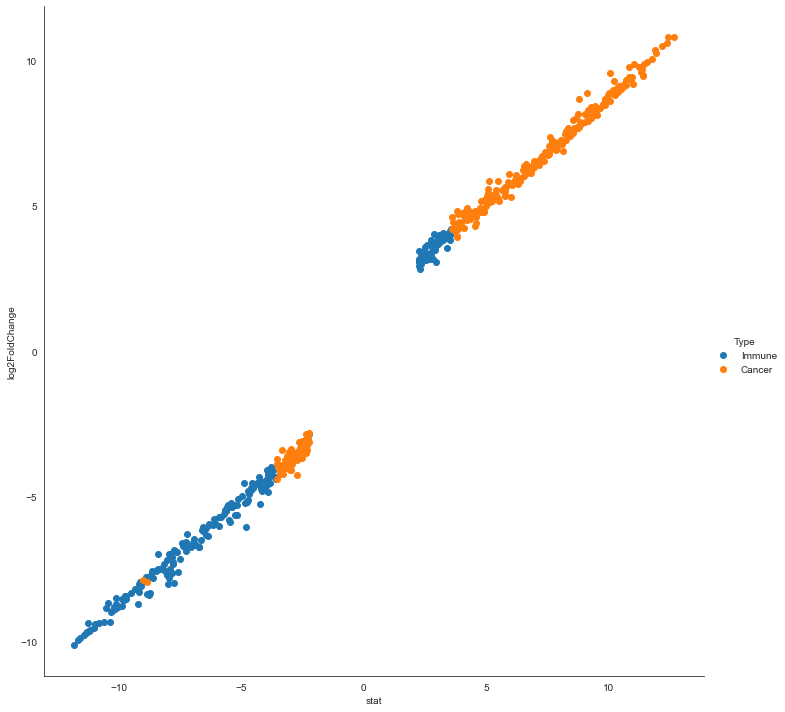

In [12]:
sns.set_style("white")
sns.FacetGrid(gene_data_wo_outliers, hue="Type", height=10) \
   .map(plt.scatter, "stat", "log2FoldChange") \
   .add_legend()
plt.show()

### Descriptive statistics

In [13]:
pd.set_option('display.width', 100)
pd.set_option('precision', 3)
description = gene_data_wo_outliers.describe()
print(description)

       baseMean  log2FoldChange    lfcSE     stat     pvalue       padj
count   548.000         548.000  548.000  548.000  5.480e+02  5.480e+02
mean     25.768           0.588    1.043    0.707  2.217e-03  4.653e-03
std      45.215           6.202    0.168    6.646  5.371e-03  1.079e-02
min       1.127         -10.115    0.828  -11.840  9.328e-37  2.767e-35
25%       2.596          -4.783    0.896   -4.592  7.093e-17  6.788e-16
50%       6.837           3.215    0.985    2.429  3.265e-08  1.524e-07
75%      26.101           6.086    1.177    6.441  6.241e-04  1.686e-03
max     321.830          10.818    1.549   12.664  2.563e-02  4.949e-02


#### Checking for class label distribution

##### Checking whether class labels are imbalanced or not

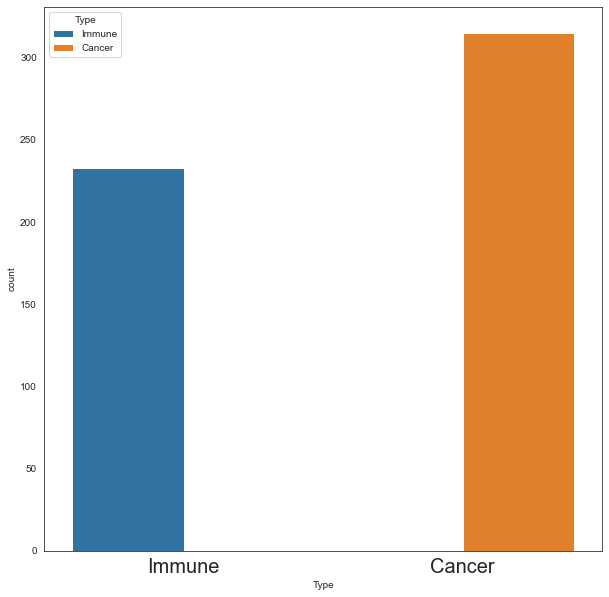

In [14]:
plt.figure(figsize=(10,10))
plt.rcParams["xtick.labelsize"] = 20
imbalance = sns.countplot(x='Type',hue="Type",data=gene_data_wo_outliers)

From the above plot, it is not completely imbalanced i.e. **82** data points are missing in ***Immune*** class label when compared with ***Cancer*** class label. Hence, we could do resampling, generate synthetic data using libraries such as SMOTE.

#### Correlation between features

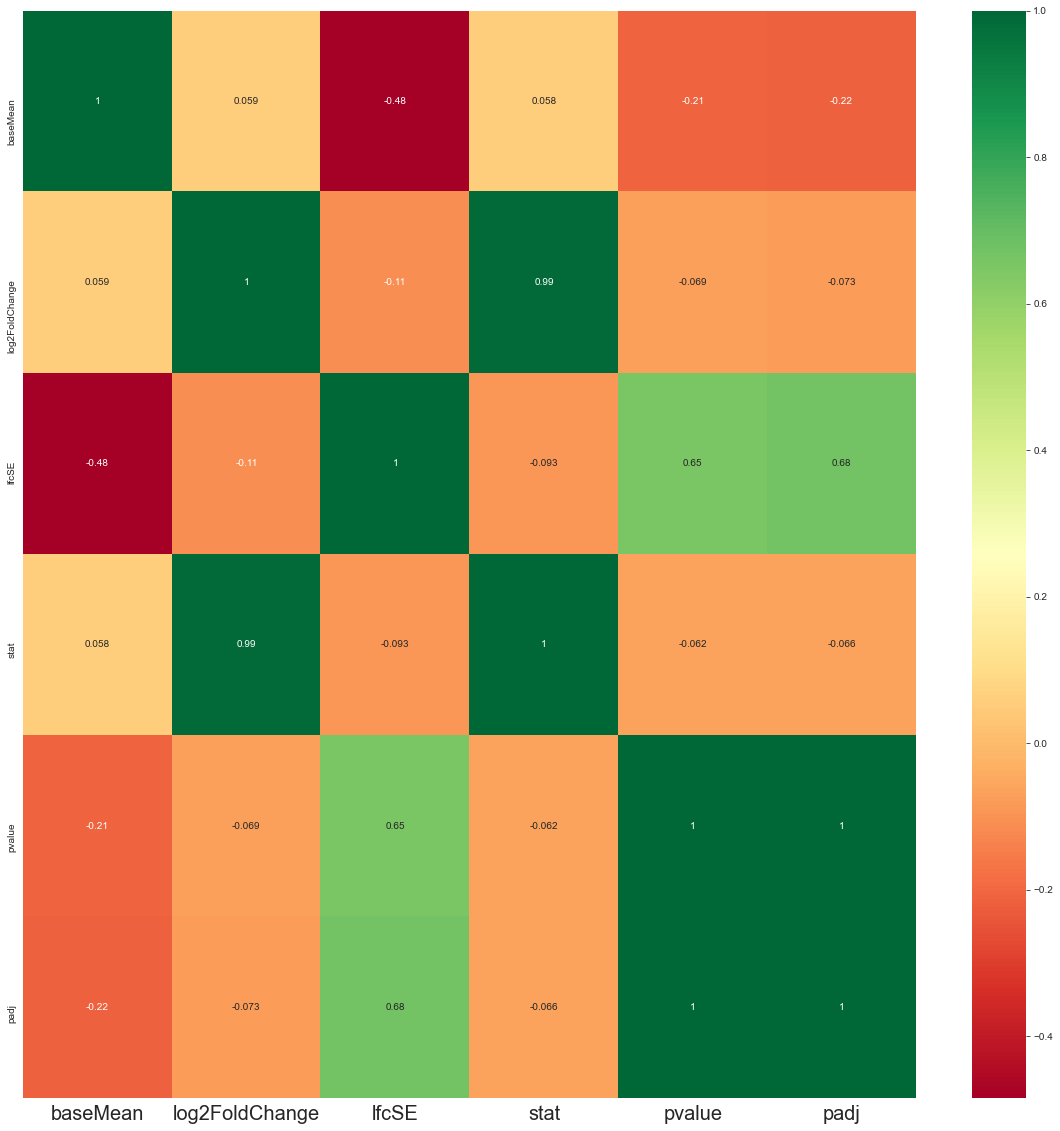

In [15]:
correlation_Matrix = gene_data_wo_outliers.corr()
features = correlation_Matrix.index
plt.figure(figsize=(20,20))
heatmap = sns.heatmap(gene_data[features].corr(),annot=True,cmap="RdYlGn")

In [16]:
print(correlation_Matrix)

                baseMean  log2FoldChange  lfcSE   stat  pvalue   padj
baseMean           1.000           0.143 -0.507  0.150  -0.221 -0.230
log2FoldChange     0.143           1.000 -0.139  0.994  -0.075 -0.080
lfcSE             -0.507          -0.139  1.000 -0.133   0.684  0.706
stat               0.150           0.994 -0.133  1.000  -0.070 -0.074
pvalue            -0.221          -0.075  0.684 -0.070   1.000  0.999
padj              -0.230          -0.080  0.706 -0.074   0.999  1.000


From the above heatmap and correlation matrix, it can be seen that ***log2FoldChange***, ***stat***, ***pvalue***, and ***padj*** are highly positive correlated which might decrease the performance of classification algorithms.

#### Checking the data distribution against each feature

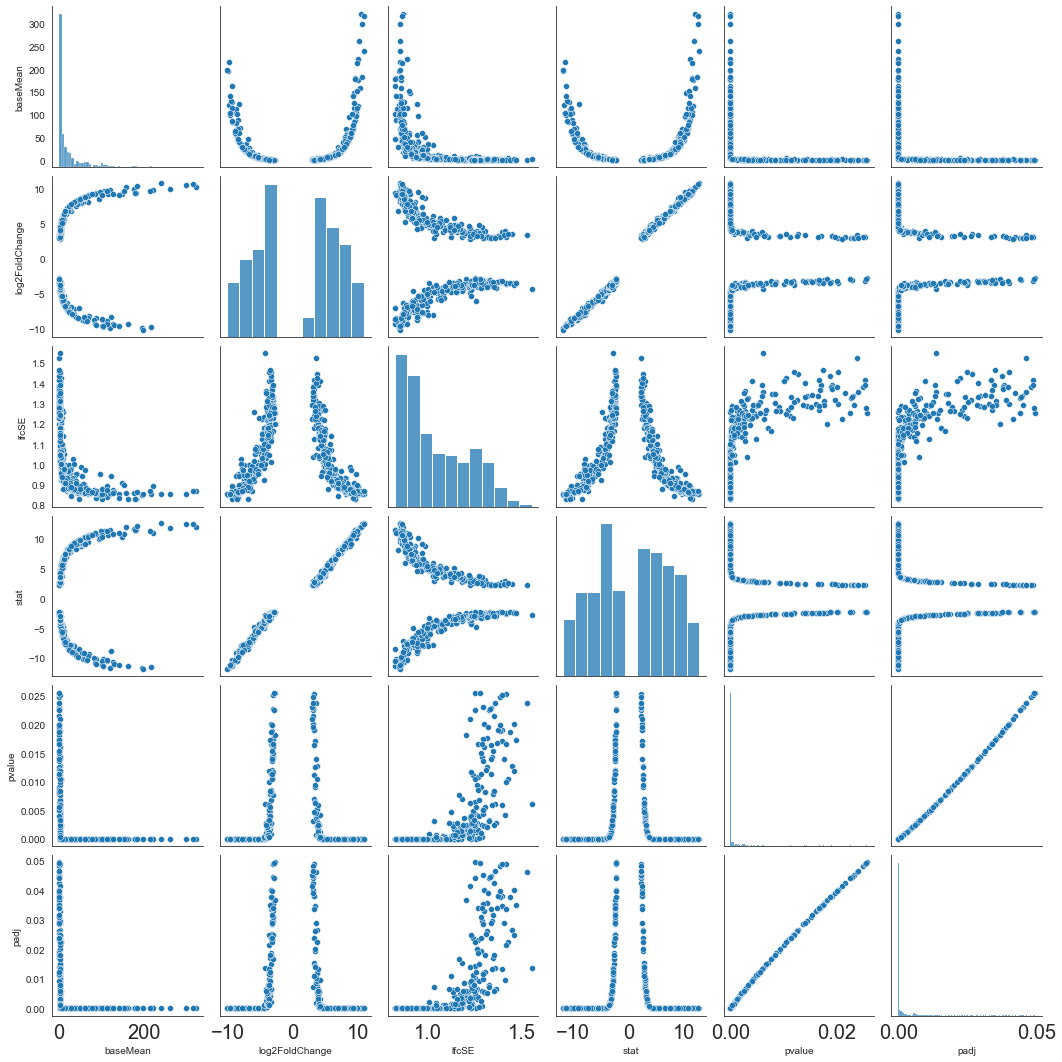

In [17]:
sns.pairplot(gene_data_wo_outliers)

Along the diagonal, we could see the histogram representing the data distribution across all the features. Except, ***log2FoldChange*** and ***stat*** all other features have positively skewed data distribution. 

In [18]:
skew = gene_data_wo_outliers.skew()
print(skew)

baseMean          3.289
log2FoldChange   -0.088
lfcSE             0.697
stat             -0.082
pvalue            2.796
padj              2.646
dtype: float64


From the above skew table, ***baseMean***, ***pvalue***, and ***padj*** are highly positively skewed and requires data transformation to reduce skewness.

In [19]:
np.log(gene_data_wo_outliers['baseMean']).skew()

0.4903075599994971

In [20]:
from scipy.stats import boxcox
first_array = boxcox(gene_data_wo_outliers['padj']+1)[0]
second_array = boxcox(gene_data_wo_outliers['pvalue']+1)[0]
v = pd.DataFrame(first_array,columns=["padj"])
v['pvalue'] = second_array
v.skew()

padj      1.372
pvalue    1.452
dtype: float64

In [21]:
gene_data_wo_outliers['baseMean'] = np.log(gene_data_wo_outliers['baseMean'])

<ipython-input-21-4752c0d08285>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_data_wo_outliers['baseMean'] = np.log(gene_data_wo_outliers['baseMean'])


In [22]:
gene_data_wo_outliers['baseMean'].skew()

0.4903075599994971

In [23]:
gene_data_wo_outliers['pvalue'] = boxcox(gene_data_wo_outliers['pvalue']+1)[0]
gene_data_wo_outliers['padj'] = boxcox(gene_data_wo_outliers['padj']+1)[0]

<ipython-input-23-b2d0e239df29>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_data_wo_outliers['pvalue'] = boxcox(gene_data_wo_outliers['pvalue']+1)[0]
<ipython-input-23-b2d0e239df29>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_data_wo_outliers['padj'] = boxcox(gene_data_wo_outliers['padj']+1)[0]


In [24]:
skew = gene_data_wo_outliers.skew()
print(skew)

baseMean          0.490
log2FoldChange   -0.088
lfcSE             0.697
stat             -0.082
pvalue            1.452
padj              1.372
dtype: float64


In [25]:
gene_data_wo_outliers.head()

,Genes,hgnc_symbol,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,DR_UR,Type
0,ENSG00000010626,LRRC23,1.032,-4.403,1.111,-3.963,7.305e-05,2.249e-04,DR,Immune
1,ENSG00000028277,POU2F2,3.773,-8.366,0.951,-8.797,0.000e+00,0.000e+00,DR,Immune
2,ENSG00000072952,MRVI1,1.921,-5.222,0.959,-5.444,5.213e-08,2.379e-07,DR,Immune
3,ENSG00000089820,ARHGAP4,2.449,-6.495,0.974,-6.665,2.638e-11,1.632e-10,DR,Immune
4,ENSG00000104522,TSTA3,3.174,-7.543,0.929,-8.119,4.441e-16,4.219e-15,DR,Immune


In [ ]:
gene_data_wo_outliers.to_csv("../Data/Preprocessed_gene_data.csv")

#### Segregating independent and dependent variables

In [26]:
x = gene_data_wo_outliers.iloc[:,2:9]
y = gene_data_wo_outliers.iloc[:,-1].to_frame(name="Type")
x = pd.get_dummies(x,columns=['DR_UR'],prefix = "Gene")

lb_make = LabelEncoder()
y['Type'] = lb_make.fit_transform(y['Type'])
y.Type.value_counts()
# 1- Immune and 0- Cancer

0    315
1    233
Name: Type, dtype: int64

In [27]:
x.columns

Index(['baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue', 'padj', 'Gene_DR', 'Gene_UR'], dtype='object')

In [28]:
x_values = x.values
y_values = y.values

#### Feature Selection using PCA

In [29]:
sc_PCA = StandardScaler()
x_pca = x
X_pca = sc_PCA.fit_transform(x_pca)
pca = PCA(.95)
pca.fit(X_pca)

PCA(n_components=0.95)

In [30]:
n_components = pca.components_.shape[0]
pca.explained_variance_ratio_.round(2)

array([0.53, 0.38, 0.06])

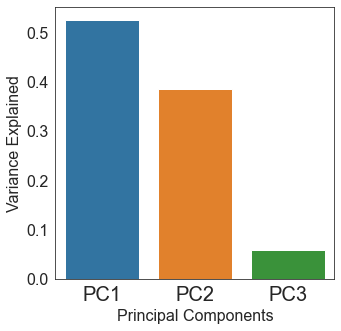

In [198]:
fig, ax = plt.subplots(figsize=(5, 5))
df = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'PC':['PC1','PC2','PC3']})
plt.rcParams.update({'font.size': 19})
chart = sns.barplot(x='PC',y="var", 
           data=df);
ax.set(xlabel='Principal Components', ylabel='Variance Explained')
plt.show()

In [31]:
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_components)]
x.columns[most_important]

Index(['log2FoldChange', 'padj', 'baseMean'], dtype='object')

#### Data preparation - with all and selected features

In [59]:
# With selected features
x_selected = x_values[:,[0,1,5]]
y_selected = y_values

# With all features
x_all = x_values
y_all = y_values

In [60]:
train_ratio = 0.75
# validation_ratio = 0.15
test_ratio = 0.25

#with all features
X_train, X_test, Y_train, Y_test = train_test_split(x_all, y_all,test_size= test_ratio, random_state=0)
#X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=validation_ratio) 

#Scaling
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
#X_val = sc_X.transform(X_val)

In [61]:
#with selected features
X_train_sel, X_test_sel, Y_train_sel, Y_test_sel = train_test_split(x_selected, y_selected,test_size= test_ratio, random_state=0)
#X_train_sel, X_val_sel, Y_train_sel, Y_val_sel = train_test_split(X_train_sel, Y_train_sel, test_size=validation_ratio)

#Scaling
sc_X_sel = StandardScaler()
X_train_sel = sc_X_sel.fit_transform(X_train_sel)
X_test_sel = sc_X_sel.transform(X_test_sel)
#X_val_sel = sc_X_sel.transform(X_val_sel)


### Decision Tree - without hyperparameters

#### With all and selected features

In [62]:
# Create Decision Tree classifer object
clf_all = DecisionTreeClassifier(criterion="gini", splitter="random")
clf_sel = DecisionTreeClassifier(criterion="gini", splitter="random")

# Train Decision Tree Classifer with all features
classifier_all = clf_all.fit(X_train,Y_train)
classifier_sel = clf_sel.fit(X_train_sel,Y_train_sel)

#Predict the response for train_all and train_selected dataset
Y_pred_train_all = classifier_all.predict(X_train)
Y_pred_train_sel = classifier_sel.predict(X_train_sel)

#Predict the response for test_all and test_selected dataset
Y_pred_test_all = classifier_all.predict(X_test)
Y_pred_test_sel = classifier_sel.predict(X_test_sel)

#Predict the response for val_all and val_selected dataset
# Y_pred_val_all = classifier_all.predict(X_val)
# Y_pred_val_sel = classifier_sel.predict(X_val_sel)


In [63]:
print("Training metrics")
print("============================")
print("Train_Accuracy_all:",round(metrics.accuracy_score(Y_train, Y_pred_train_all),2))
print("Train_Accuracy_sel:",round(metrics.accuracy_score(Y_train_sel, Y_pred_train_sel),2))
print("Train_precision_recall_f1_score_all:",precision_recall_fscore_support(Y_train, Y_pred_train_all, average='binary'))
print("Train_precision_recall_f1_score_sel:",precision_recall_fscore_support(Y_train_sel, Y_pred_train_sel, average='binary'))
print("\n")
print("Testing metrics")
print("============================")
print("Test_Accuracy_all:",round(metrics.accuracy_score(Y_test, Y_pred_test_all),2))
print("Test_Accuracy_sel:",round(metrics.accuracy_score(Y_test_sel, Y_pred_test_sel),2))
print("Test_precision_recall_f1_score_all:",precision_recall_fscore_support(Y_test, Y_pred_test_all, average='binary'))
print("Test_precision_recall_f1_score_sel:",precision_recall_fscore_support(Y_test_sel, Y_pred_test_sel, average='binary'))
# print("\n")
# print("Validation metrics")
# print("============================")
# print("Val_Accuracy_all:",round(metrics.accuracy_score(Y_val, Y_pred_val_all),2))
# print("Val_Accuracy_sel:",round(metrics.accuracy_score(Y_val_sel, Y_pred_val_sel),2))
# print("Val_precision_recall_f1_score_hyp_all:",precision_recall_fscore_support(Y_val, Y_pred_val_all, average='binary'))
# print("Val_precision_recall_f1_score_sel:",precision_recall_fscore_support(Y_val_sel, Y_pred_val_sel, average='binary'))




Training metrics
Train_Accuracy_all: 1.0
Train_Accuracy_sel: 1.0
Train_precision_recall_f1_score_all: (1.0, 1.0, 1.0, None)
Train_precision_recall_f1_score_sel: (1.0, 1.0, 1.0, None)


Testing metrics
Test_Accuracy_all: 0.96
Test_Accuracy_sel: 0.95
Test_precision_recall_f1_score_all: (0.9795918367346939, 0.9056603773584906, 0.9411764705882353, None)
Test_precision_recall_f1_score_sel: (0.9423076923076923, 0.9245283018867925, 0.9333333333333333, None)


### Finding hyperparameters for Decision tree

In [64]:
param_grid = {
    "max_depth": [3,5,10,15,20,None],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

clf_cv_all = DecisionTreeClassifier(criterion="gini", splitter="random")
clf_cv_sel = DecisionTreeClassifier(criterion="gini", splitter="random")
grid_cv_all = GridSearchCV(clf_cv_all, param_grid, scoring="f1", n_jobs=-1, cv=3).fit(X_train, Y_train)
grid_cv_sel = GridSearchCV(clf_cv_sel, param_grid, scoring="f1", n_jobs=-1, cv=3).fit(X_train_sel, Y_train_sel)

print("Data with all features")
print("Param for DT with all features", grid_cv_all.best_params_)
print("CV score for DT with all features", grid_cv_all.best_score_)
print("Train F1 Score for train with all features: ", metrics.f1_score(Y_train, grid_cv_all.predict(X_train)))
print("Test F1 Score for test with all features: ", metrics.f1_score(Y_test, grid_cv_all.predict(X_test)))
# print("Test F1 Score for valid with all features: ", metrics.f1_score(Y_val, grid_cv_all.predict(X_val)))

print("\n")
print("PCA dataset")
print("Param for DT with all features", grid_cv_all.best_params_)
print("CV score for DT with all features", grid_cv_all.best_score_)
print("Train F1 Score for train with selected features: ", metrics.f1_score(Y_train_sel, grid_cv_sel.predict(X_train_sel)))
print("Test F1 Score for test with selected features: ", metrics.f1_score(Y_test_sel, grid_cv_sel.predict(X_test_sel)))
# print("Test F1 Score for valid with selected features: ", metrics.f1_score(Y_val_sel, grid_cv_sel.predict(X_val_sel)))


print("Classification report for data with all features")
grid_dt_all_prediction_train = grid_cv_all.predict(X_train)

# print classification report 
print(metrics.classification_report(Y_train, grid_dt_all_prediction_train)) 

grid_dt_all_prediction_test = grid_cv_all.predict(X_test) 
  
# print classification report 
print(metrics.classification_report(Y_test, grid_dt_all_prediction_test)) 

# grid_dt_all_prediction_val = grid_cv_all.predict(X_val) 
  
# print classification report 
# print(metrics.classification_report(Y_val, grid_dt_all_prediction_val)) 


print("\n Classification report for data with selected features")
grid_dt_sel_prediction_train = grid_cv_sel.predict(X_train_sel)

# print classification report 
print(metrics.classification_report(Y_train_sel, grid_dt_sel_prediction_train)) 

grid_dt_sel_prediction_test = grid_cv_sel.predict(X_test_sel) 
  
# print classification report 
print(metrics.classification_report(Y_test_sel, grid_dt_sel_prediction_test)) 

# grid_dt_sel_prediction_val = grid_cv_sel.predict(X_val_sel) 
  
# print classification report 
# print(metrics.classification_report(Y_val_sel, grid_dt_sel_prediction_val)) 



Data with all features
Param for DT with all features {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 7}
CV score for DT with all features 0.9836054558892696
Train F1 Score for train with all features:  0.9775280898876404
Test F1 Score for test with all features:  0.9607843137254902


PCA dataset
Param for DT with all features {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 7}
CV score for DT with all features 0.9836054558892696
Train F1 Score for train with selected features:  0.9608938547486034
Test F1 Score for test with selected features:  0.9523809523809524
Classification report for data with all features
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       231
           1       0.99      0.97      0.98       180

    accuracy                           0.98       411
   macro avg       0.98      0.98      0.98       411
weighted avg       0.98      0.98      0.98       411

              precision    

Selected hyperparameters are <b>max_depth=3, min_samples_leaf=1, min_samples_split=2</b>

### Decision Tree - with hyperparameters

In [65]:
# Create Decision Tree classifer object with hyperparameters
clf_all_hyp = DecisionTreeClassifier(criterion="gini", splitter="random",max_depth=3,min_samples_leaf=1,min_samples_split=2)
clf_sel_hyp = DecisionTreeClassifier(criterion="gini", splitter="random",max_depth=3,min_samples_leaf=1,min_samples_split=2)

# Train Decision Tree Classifer with all features
classifier_hyp_all = clf_all_hyp.fit(X_train,Y_train)

# Train Decision Tree Classifer with selected features
classifier_hyp_sel = clf_sel_hyp.fit(X_train_sel,Y_train_sel)

#Predict the response for train_all and train_selected dataset
Y_pred_hyp_train_all = classifier_hyp_all.predict(X_train)
Y_pred_hyp_train_sel = classifier_hyp_sel.predict(X_train_sel)

#Predict the response for test_all and test_selected dataset
Y_pred_hyp_test_all = classifier_hyp_all.predict(X_test)
Y_pred_hyp_test_sel = classifier_hyp_sel.predict(X_test_sel)

#Predict the response for val_all and val_selected dataset
# Y_pred_hyp_val_all = classifier_hyp_all.predict(X_val)
# Y_pred_hyp_val_sel = classifier_hyp_sel.predict(X_val_sel)


In [66]:
print("Training metrics")
print("============================")
print("Train_Accuracy_all:",round(metrics.accuracy_score(Y_train, Y_pred_hyp_train_all),2))
print("Train_Accuracy_sel:",round(metrics.accuracy_score(Y_train_sel, Y_pred_hyp_train_sel),2))
print("Train_precision_recall_f1_score_hyp_all:",precision_recall_fscore_support(Y_train, Y_pred_hyp_train_all, average='binary'))
print("Train_precision_recall_f1_score_hyp_sel:",precision_recall_fscore_support(Y_train_sel, Y_pred_hyp_train_sel, average='binary'))
print("\n")
print("Testing metrics")
print("============================")
print("Test_Accuracy_all:",round(metrics.accuracy_score(Y_test, Y_pred_hyp_test_all),2))
print("Test_Accuracy_sel:",round(metrics.accuracy_score(Y_test_sel, Y_pred_hyp_test_sel),2))
print("Test_precision_recall_f1_score_hyp_all:",precision_recall_fscore_support(Y_test, Y_pred_hyp_test_all, average='binary'))
print("Test_precision_recall_f1_score_hyp_sel:",precision_recall_fscore_support(Y_test_sel, Y_pred_hyp_test_sel, average='binary'))
# print("\n")
# print("Validation metrics")
# print("============================")
# print("Val_Accuracy_all:",round(metrics.accuracy_score(Y_val, Y_pred_hyp_val_all),2))
# print("Val_Accuracy_sel:",round(metrics.accuracy_score(Y_val_sel, Y_pred_hyp_val_sel),2))
# print("Val_precision_recall_f1_score_hyp_all:",precision_recall_fscore_support(Y_val, Y_pred_hyp_val_all, average='binary'))
# print("Val_precision_recall_f1_score_hyp_sel:",precision_recall_fscore_support(Y_val_sel, Y_pred_hyp_val_sel, average='binary'))



Training metrics
Train_Accuracy_all: 0.97
Train_Accuracy_sel: 0.96
Train_precision_recall_f1_score_hyp_all: (0.9720670391061452, 0.9666666666666667, 0.9693593314763231, None)
Train_precision_recall_f1_score_hyp_sel: (0.9879518072289156, 0.9111111111111111, 0.9479768786127168, None)


Testing metrics
Test_Accuracy_all: 0.99
Test_Accuracy_sel: 0.96
Test_precision_recall_f1_score_hyp_all: (1.0, 0.9622641509433962, 0.9807692307692307, None)
Test_precision_recall_f1_score_hyp_sel: (1.0, 0.8867924528301887, 0.9400000000000001, None)


### Random Forest

#### with all and selected features

In [67]:
rf_all = RandomForestClassifier()
rf_selected = RandomForestClassifier()

rf_classifier_all = rf_all.fit(X_train,Y_train)
rf_classifier_selected = rf_selected.fit(X_train_sel,Y_train_sel)

#Predict the response for train_all and train_selected dataset
Y_pred_rf_train_all = rf_classifier_all.predict(X_train)
Y_pred_rf_train_selected = rf_classifier_selected.predict(X_train_sel)

#Predict the response for test_all and test_selected dataset
Y_pred_rf_test_all = rf_classifier_all.predict(X_test)
Y_pred_rf_test_selected = rf_classifier_selected.predict(X_test_sel)

#Predict the response for val_all and val_selected dataset
# Y_pred_rf_val_all = rf_classifier_all.predict(X_val)
# Y_pred_rf_val_selected = rf_classifier_selected.predict(X_val_sel)

<ipython-input-67-b7f349479b0b>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier_all = rf_all.fit(X_train,Y_train)
<ipython-input-67-b7f349479b0b>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier_selected = rf_selected.fit(X_train_sel,Y_train_sel)


In [68]:
print("Training Metrics")
print("============================")
print("RF_Accuracy_all:",round(metrics.accuracy_score(Y_train, Y_pred_rf_train_all),2))
print("RF_Accuracy_selected:",round(metrics.accuracy_score(Y_train_sel, Y_pred_rf_train_selected),2))
print("RF_Train_precision_recall_f1_score_all:",precision_recall_fscore_support(Y_train, Y_pred_rf_train_all, average='binary'))
print("RF_Train_precision_recall_f1_score_sel:",precision_recall_fscore_support(Y_train_sel, Y_pred_rf_train_selected, average='binary'))
print("\n")
print("Testing Metrics")
print("============================")
print("RF_Accuracy_all:",round(metrics.accuracy_score(Y_test, Y_pred_rf_test_all),2))
print("RF_Accuracy_selected:",round(metrics.accuracy_score(Y_test_sel, Y_pred_rf_test_selected),2))
print("RF_Test_precision_recall_f1_score_all:",precision_recall_fscore_support(Y_test, Y_pred_rf_test_all, average='binary'))
print("RF_Test_precision_recall_f1_score_sel:",precision_recall_fscore_support(Y_test_sel, Y_pred_rf_test_selected, average='binary'))
# print("\n")
# print("Validation Metrics")
# print("============================")
# print("RF_Accuracy_all:",round(metrics.accuracy_score(Y_val, Y_pred_rf_val_all),2))
# print("RF_Accuracy_selected:",round(metrics.accuracy_score(Y_val_sel, Y_pred_rf_val_selected),2))
# print("RF_Val_precision_recall_f1_score_all:",precision_recall_fscore_support(Y_val, Y_pred_rf_val_all, average='binary'))
# print("RF_Val_precision_recall_f1_score_sel:",precision_recall_fscore_support(Y_val_sel, Y_pred_rf_val_selected, average='binary'))


Training Metrics
RF_Accuracy_all: 1.0
RF_Accuracy_selected: 1.0
RF_Train_precision_recall_f1_score_all: (1.0, 1.0, 1.0, None)
RF_Train_precision_recall_f1_score_sel: (1.0, 1.0, 1.0, None)


Testing Metrics
RF_Accuracy_all: 0.99
RF_Accuracy_selected: 0.99
RF_Test_precision_recall_f1_score_all: (1.0, 0.9622641509433962, 0.9807692307692307, None)
RF_Test_precision_recall_f1_score_sel: (1.0, 0.9622641509433962, 0.9807692307692307, None)


### Finding hyperparameters for Random Forest

In [69]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

rf_cv_all = RandomForestClassifier()
rf_cv_sel = RandomForestClassifier()
grid_cv_all = GridSearchCV(rf_cv_all, param_grid, scoring="f1", n_jobs=-1, cv=3).fit(X_train, Y_train)
grid_cv_sel = GridSearchCV(rf_cv_sel, param_grid, scoring="f1", n_jobs=-1, cv=3).fit(X_train_sel, Y_train_sel)

print("Data with all features")
print("Param for DT with all features", grid_cv_all.best_params_)
print("CV score for DT with all features", grid_cv_all.best_score_)
print("Train F1 Score for train with all features: ", metrics.f1_score(Y_train, grid_cv_all.predict(X_train)))
print("Test F1 Score for test with all features: ", metrics.f1_score(Y_test, grid_cv_all.predict(X_test)))
# print("Test F1 Score for valid with all features: ", metrics.f1_score(Y_val, grid_cv_all.predict(X_val)))

print("\n")
print("PCA dataset")
print("Param for DT with all features", grid_cv_all.best_params_)
print("CV score for DT with all features", grid_cv_all.best_score_)
print("Train F1 Score for train with selected features: ", metrics.f1_score(Y_train_sel, grid_cv_sel.predict(X_train_sel)))
print("Test F1 Score for test with selected features: ", metrics.f1_score(Y_test_sel, grid_cv_sel.predict(X_test_sel)))
# print("Test F1 Score for valid with selected features: ", metrics.f1_score(Y_val_sel, grid_cv_sel.predict(X_val_sel)))


print("Classification report for data with all features")
grid_rf_all_prediction_train = grid_cv_all.predict(X_train)

# print classification report 
print(metrics.classification_report(Y_train, grid_rf_all_prediction_train)) 

grid_rf_all_prediction_test = grid_cv_all.predict(X_test) 
  
# print classification report 
print(metrics.classification_report(Y_test, grid_rf_all_prediction_test)) 

# grid_rf_all_prediction_val = grid_cv_all.predict(X_val) 
  
# print classification report 
# print(metrics.classification_report(Y_val, grid_rf_all_prediction_val)) 


print("\n Classification report for data with selected features")
grid_rf_sel_prediction_train = grid_cv_sel.predict(X_train_sel)

# print classification report 
print(metrics.classification_report(Y_train_sel, grid_rf_sel_prediction_train)) 

grid_rf_sel_prediction_test = grid_cv_sel.predict(X_test_sel) 
  
# print classification report 
print(metrics.classification_report(Y_test_sel, grid_rf_sel_prediction_test)) 

# grid_rf_sel_prediction_val = grid_cv_sel.predict(X_val_sel) 
  
# print classification report 
# print(metrics.classification_report(Y_val_sel, grid_rf_sel_prediction_val)) 


/Users/lawrence/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
/Users/lawrence/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Data with all features
Param for DT with all features {'bootstrap': True, 'max_depth': 90, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 200}
CV score for DT with all features 0.9861795958052642
Train F1 Score for train with all features:  0.9916897506925207
Test F1 Score for test with all features:  0.9807692307692307


PCA dataset
Param for DT with all features {'bootstrap': True, 'max_depth': 90, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 200}
CV score for DT with all features 0.9861795958052642
Train F1 Score for train with selected features:  0.9861495844875346
Test F1 Score for test with selected features:  0.9807692307692307
Classification report for data with all features
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       231
           1       0.99      0.99      0.99       180

    accuracy                           0.99       411
   macro avg      

### Random Forest with hyperparameters

In [70]:
rf_hyp_all = RandomForestClassifier(bootstrap = True, max_depth=80, max_features = 3, min_samples_leaf = 3,
                                   min_samples_split = 8, n_estimators = 300)
rf_hyp_selected = RandomForestClassifier(bootstrap = True, max_depth=80, max_features = 3, min_samples_leaf = 3,
                                   min_samples_split = 8, n_estimators = 300)

rf_hyp_classifier_all = rf_hyp_all.fit(X_train,Y_train)
rf_hyp_classifier_selected = rf_hyp_selected.fit(X_train_sel,Y_train_sel)

#Predict the response for train_all and train_selected dataset
Y_pred_rf_hyp_train_all = rf_hyp_classifier_all.predict(X_train)
Y_pred_rf_hyp_train_selected = rf_hyp_classifier_selected.predict(X_train_sel)

#Predict the response for test_all and test_selected dataset
Y_pred_rf_hyp_test_all = rf_hyp_classifier_all.predict(X_test)
Y_pred_rf_hyp_test_selected = rf_hyp_classifier_selected.predict(X_test_sel)

#Predict the response for val_all and val_selected dataset
# Y_pred_rf_hyp_val_all = rf_hyp_classifier_all.predict(X_val)
# Y_pred_rf_hyp_val_selected = rf_hyp_classifier_selected.predict(X_val_sel)

<ipython-input-70-380306c8368d>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_hyp_classifier_all = rf_hyp_all.fit(X_train,Y_train)
<ipython-input-70-380306c8368d>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_hyp_classifier_selected = rf_hyp_selected.fit(X_train_sel,Y_train_sel)


In [71]:
print("Training Metrics")
print("============================")
print("RF_hyp_Accuracy_all:",round(metrics.accuracy_score(Y_train, Y_pred_rf_hyp_train_all),2))
print("RF_hyp_Accuracy_selected:",round(metrics.accuracy_score(Y_train_sel, Y_pred_rf_hyp_train_selected),2))
print("RF_Train_precision_recall_f1_score_hyp_all:",precision_recall_fscore_support(Y_train, Y_pred_rf_hyp_train_all, average='binary'))
print("RF_Train_precision_recall_f1_score_hyp_sel:",precision_recall_fscore_support(Y_train_sel, Y_pred_rf_hyp_train_selected, average='binary'))
print("\n")
print("Testing Metrics")
print("============================")
print("RF_hyp_Accuracy_all:",round(metrics.accuracy_score(Y_test, Y_pred_rf_hyp_test_all),2))
print("RF_hyp_Accuracy_selected:",round(metrics.accuracy_score(Y_test_sel, Y_pred_rf_hyp_test_selected),2))
print("RF_Test_precision_recall_f1_score_hyp_all:",precision_recall_fscore_support(Y_test, Y_pred_rf_hyp_test_all, average='binary'))
print("RF_Test_precision_recall_f1_score_hyp_sel:",precision_recall_fscore_support(Y_test_sel, Y_pred_rf_hyp_test_selected, average='binary'))
# print("\n")
# print("Validation Metrics")
# print("============================")
# print("RF_hyp_Accuracy_all:",round(metrics.accuracy_score(Y_val, Y_pred_rf_hyp_val_all),2))
# print("RF_hyp_Accuracy_selected:",round(metrics.accuracy_score(Y_val_sel, Y_pred_rf_hyp_val_selected),2))
# print("RF_Val_precision_recall_f1_score_hyp_all:",precision_recall_fscore_support(Y_val, Y_pred_rf_hyp_val_all, average='binary'))
# print("RF_Val_precision_recall_f1_score_hyp_sel:",precision_recall_fscore_support(Y_val_sel, Y_pred_rf_hyp_val_selected, average='binary'))


Training Metrics
RF_hyp_Accuracy_all: 0.99
RF_hyp_Accuracy_selected: 0.99
RF_Train_precision_recall_f1_score_hyp_all: (0.988950276243094, 0.9944444444444445, 0.9916897506925207, None)
RF_Train_precision_recall_f1_score_hyp_sel: (0.9834254143646409, 0.9888888888888889, 0.9861495844875346, None)


Testing Metrics
RF_hyp_Accuracy_all: 0.99
RF_hyp_Accuracy_selected: 0.99
RF_Test_precision_recall_f1_score_hyp_all: (1.0, 0.9622641509433962, 0.9807692307692307, None)
RF_Test_precision_recall_f1_score_hyp_sel: (1.0, 0.9622641509433962, 0.9807692307692307, None)


### SVM

#### With all and selected features

#### with RBF Kernel

In [72]:
svclassifier_rbf_all = SVC(kernel='rbf',probability=True).fit(X_train, Y_train)
svclassifier_rbf_sel = SVC(kernel='rbf',probability=True).fit(X_train_sel, Y_train_sel)

#Prediction and evaluation
# Training prediction
Y_svm_train_pred_all = svclassifier_rbf_all.predict(X_train)
Y_svm_train_pred_sel = svclassifier_rbf_sel.predict(X_train_sel)

# Testing prediction
Y_svm_test_pred_all = svclassifier_rbf_all.predict(X_test)
Y_svm_test_pred_sel = svclassifier_rbf_sel.predict(X_test_sel)

# # Validation prediction
# Y_svm_val_pred_all = svclassifier_rbf_all.predict(X_val)
# Y_svm_val_pred_sel = svclassifier_rbf_sel.predict(X_val_sel)



/Users/lawrence/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/lawrence/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [73]:
print("Training Metrics")
print("============================")
print("SVM_Accuracy_all:",round(metrics.accuracy_score(Y_train, Y_svm_train_pred_all),2))
print("SVM_Accuracy_selected:",round(metrics.accuracy_score(Y_train_sel, Y_svm_train_pred_sel),2))
print("SVM_Train_precision_recall_f1_score_all:",precision_recall_fscore_support(Y_train, Y_svm_train_pred_all, average='binary'))
print("SVM_Train_precision_recall_f1_score_sel:",precision_recall_fscore_support(Y_train_sel, Y_svm_train_pred_sel, average='binary'))
print("\n")
print("Testing Metrics")
print("============================")
print("SVM_Accuracy_all:",round(metrics.accuracy_score(Y_test, Y_svm_test_pred_all),2))
print("SVM_Accuracy_selected:",round(metrics.accuracy_score(Y_test_sel, Y_svm_test_pred_sel),2))
print("SVM_Test_precision_recall_f1_score_all:",precision_recall_fscore_support(Y_test, Y_svm_test_pred_all, average='binary'))
print("SVM_Test_precision_recall_f1_score_sel:",precision_recall_fscore_support(Y_test_sel, Y_svm_test_pred_sel, average='binary'))
# print("\n")
# print("Validation Metrics")
# print("============================")
# print("SVM_Accuracy_all:",round(metrics.accuracy_score(Y_val, Y_svm_val_pred_all),2))
# print("SVM_Accuracy_selected:",round(metrics.accuracy_score(Y_val_sel, Y_svm_val_pred_sel),2))
# print("SVM_Val_precision_recall_f1_score_all:",precision_recall_fscore_support(Y_val, Y_svm_val_pred_all, average='binary'))
# print("SVM_Val_precision_recall_f1_score_sel:",precision_recall_fscore_support(Y_val_sel, Y_svm_val_pred_sel, average='binary'))


Training Metrics
SVM_Accuracy_all: 0.98
SVM_Accuracy_selected: 0.97
SVM_Train_precision_recall_f1_score_all: (0.9672131147540983, 0.9833333333333333, 0.9752066115702478, None)
SVM_Train_precision_recall_f1_score_sel: (0.9668508287292817, 0.9722222222222222, 0.9695290858725762, None)


Testing Metrics
SVM_Accuracy_all: 0.98
SVM_Accuracy_selected: 0.99
SVM_Test_precision_recall_f1_score_all: (0.9807692307692307, 0.9622641509433962, 0.9714285714285713, None)
SVM_Test_precision_recall_f1_score_sel: (1.0, 0.9622641509433962, 0.9807692307692307, None)


#### With Sigmoid kernel

In [74]:
svclassifier_sig_all = SVC(kernel='sigmoid',probability=True).fit(X_train, Y_train)
svclassifier_sig_sel = SVC(kernel='sigmoid',probability=True).fit(X_train_sel, Y_train_sel)

#Prediction and evaluation
# Training prediction
Y_svm_sig_train_pred_all = svclassifier_sig_all.predict(X_train)
Y_svm_sig_train_pred_sel = svclassifier_sig_sel.predict(X_train_sel)

# Testing prediction
Y_svm_sig_test_pred_all = svclassifier_sig_all.predict(X_test)
Y_svm_sig_test_pred_sel = svclassifier_sig_sel.predict(X_test_sel)

# # Validation prediction
# Y_svm_sig_val_pred_all = svclassifier_sig_all.predict(X_val)
# Y_svm_sig_val_pred_sel = svclassifier_sig_sel.predict(X_val_sel)


/Users/lawrence/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/lawrence/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [75]:
print("Training Metrics")
print("============================")
print("SVM_sig_Accuracy_all:",round(metrics.accuracy_score(Y_train, Y_svm_sig_train_pred_all),2))
print("SVM_sig_Accuracy_selected:",round(metrics.accuracy_score(Y_train_sel, Y_svm_sig_train_pred_sel),2))
print("SVM_sig_Train_precision_recall_f1_score_all:",precision_recall_fscore_support(Y_train, Y_svm_sig_train_pred_all, average='binary'))
print("SVM_sig_Train_precision_recall_f1_score_sel:",precision_recall_fscore_support(Y_train_sel, Y_svm_sig_train_pred_sel, average='binary'))
print("\n")
print("Testing Metrics")
print("============================")
print("SVM_sig_Accuracy_all:",round(metrics.accuracy_score(Y_test, Y_svm_sig_test_pred_all),2))
print("SVM_sig_Accuracy_selected:",round(metrics.accuracy_score(Y_test_sel, Y_svm_sig_test_pred_sel),2))
print("SVM_sig_Test_precision_recall_f1_score_all:",precision_recall_fscore_support(Y_test, Y_svm_sig_test_pred_all, average='binary'))
print("SVM_sig_Test_precision_recall_f1_score_sel:",precision_recall_fscore_support(Y_test_sel, Y_svm_sig_test_pred_sel, average='binary'))
# print("\n")
# print("Validation Metrics")
# print("============================")
# print("SVM_sig_Accuracy_all:",round(metrics.accuracy_score(Y_val, Y_svm_sig_val_pred_all),2))
# print("SVM_sig_Accuracy_selected:",round(metrics.accuracy_score(Y_val_sel, Y_svm_sig_val_pred_sel),2))
# print("SVM_sig_Val_precision_recall_f1_score_all:",precision_recall_fscore_support(Y_val, Y_svm_sig_val_pred_all, average='binary'))
# print("SVM_sig_Val_precision_recall_f1_score_sel:",precision_recall_fscore_support(Y_val_sel, Y_svm_sig_val_pred_sel, average='binary'))


Training Metrics
SVM_sig_Accuracy_all: 0.61
SVM_sig_Accuracy_selected: 0.7
SVM_sig_Train_precision_recall_f1_score_all: (0.5574712643678161, 0.5388888888888889, 0.5480225988700566, None)
SVM_sig_Train_precision_recall_f1_score_sel: (0.6666666666666666, 0.6222222222222222, 0.6436781609195403, None)


Testing Metrics
SVM_sig_Accuracy_all: 0.61
SVM_sig_Accuracy_selected: 0.71
SVM_sig_Test_precision_recall_f1_score_all: (0.5, 0.5283018867924528, 0.5137614678899083, None)
SVM_sig_Test_precision_recall_f1_score_sel: (0.6444444444444445, 0.5471698113207547, 0.5918367346938775, None)


#### With Polynomial kernel

In [80]:
svclassifier_poly_all = SVC(kernel='poly',probability=True,degree=5).fit(X_train, Y_train)
svclassifier_poly_sel = SVC(kernel='poly',probability=True, degree=5).fit(X_train_sel, Y_train_sel)

#Prediction and evaluation
# Training prediction
Y_svm_poly_train_pred_all = svclassifier_poly_all.predict(X_train)
Y_svm_poly_train_pred_sel = svclassifier_poly_sel.predict(X_train_sel)

# Testing prediction
Y_svm_poly_test_pred_all = svclassifier_poly_all.predict(X_test)
Y_svm_poly_test_pred_sel = svclassifier_poly_sel.predict(X_test_sel)

# Validation prediction
# Y_svm_poly_val_pred_all = svclassifier_poly_all.predict(X_val)
# Y_svm_poly_val_pred_sel = svclassifier_poly_sel.predict(X_val_sel)


/Users/lawrence/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/lawrence/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [81]:
print("Training Metrics")
print("============================")
print("SVM_poly_Accuracy_all:",round(metrics.accuracy_score(Y_train, Y_svm_poly_train_pred_all),2))
print("SVM_poly_Accuracy_selected:",round(metrics.accuracy_score(Y_train_sel, Y_svm_poly_train_pred_sel),2))
print("SVM_poly_Train_precision_recall_f1_score_all:",precision_recall_fscore_support(Y_train, Y_svm_poly_train_pred_all, average='binary'))
print("SVM_poly_Train_precision_recall_f1_score_sel:",precision_recall_fscore_support(Y_train_sel, Y_svm_poly_train_pred_sel, average='binary'))
print("\n")
print("Testing Metrics")
print("============================")
print("SVM_poly_Accuracy_all:",round(metrics.accuracy_score(Y_test, Y_svm_poly_test_pred_all),2))
print("SVM_poly_Accuracy_selected:",round(metrics.accuracy_score(Y_test_sel, Y_svm_poly_test_pred_sel),2))
print("SVM_poly_Test_precision_recall_f1_score_all:",precision_recall_fscore_support(Y_test, Y_svm_poly_test_pred_all, average='binary'))
print("SVM_poly_Test_precision_recall_f1_score_sel:",precision_recall_fscore_support(Y_test_sel, Y_svm_poly_test_pred_sel, average='binary'))
# print("\n")
# print("Validation Metrics")
# print("============================")
# print("SVM_poly_Accuracy_all:",round(metrics.accuracy_score(Y_val, Y_svm_poly_val_pred_all),2))
# print("SVM_poly_Accuracy_selected:",round(metrics.accuracy_score(Y_val_sel, Y_svm_poly_val_pred_sel),2))
# print("SVM_poly_Val_precision_recall_f1_score_all:",precision_recall_fscore_support(Y_val, Y_svm_poly_val_pred_all, average='binary'))
# print("SVM_poly_Val_precision_recall_f1_score_sel:",precision_recall_fscore_support(Y_val_sel, Y_svm_poly_val_pred_sel, average='binary'))


Training Metrics
SVM_poly_Accuracy_all: 0.95
SVM_poly_Accuracy_selected: 0.95
SVM_poly_Train_precision_recall_f1_score_all: (0.9542857142857143, 0.9277777777777778, 0.9408450704225352, None)
SVM_poly_Train_precision_recall_f1_score_sel: (0.9877300613496932, 0.8944444444444445, 0.9387755102040817, None)


Testing Metrics
SVM_poly_Accuracy_all: 0.91
SVM_poly_Accuracy_selected: 0.93
SVM_poly_Test_precision_recall_f1_score_all: (0.9183673469387755, 0.8490566037735849, 0.8823529411764707, None)
SVM_poly_Test_precision_recall_f1_score_sel: (0.9782608695652174, 0.8490566037735849, 0.9090909090909092, None)


### Finding hyperparameters for SVM

In [ ]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'degree':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
              'kernel': ['rbf','sigmoid','poly']}

svm_cv_all = SVC()
grid_cv_all = GridSearchCV(svm_cv_all, param_grid, scoring="f1", n_jobs=-1, cv=3).fit(X_train, Y_train)

print("Data with all features")
print("Param for DT with all features", grid_cv_all.best_params_)
print("CV score for DT with all features", grid_cv_all.best_score_)
print("Train F1 Score for train with all features: ", metrics.f1_score(Y_train, grid_cv_all.predict(X_train)))
print("Test F1 Score for test with all features: ", metrics.f1_score(Y_test, grid_cv_all.predict(X_test)))
# print("Test F1 Score for valid with all features: ", metrics.f1_score(Y_val, grid_cv_all.predict(X_val)))

print("Classification report for data with all features")
grid_svm_all_prediction_train = grid_cv_all.predict(X_train)

# print classification report 
print("Training")
print(metrics.classification_report(Y_train, grid_svm_all_prediction_train)) 

grid_svm_all_prediction_test = grid_cv_all.predict(X_test) 
  
# print classification report 
print("Testing")
print(metrics.classification_report(Y_test, grid_svm_all_prediction_test)) 

# grid_svm_all_prediction_val = grid_cv_all.predict(X_val) 
  
# print classification report 
# print("Validation")
# print(metrics.classification_report(Y_val, grid_svm_all_prediction_val)) 


In [ ]:
# defining parameter range
param_grid_sel = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf','sigmoid']}

svc_cv_sel = SVC()
grid_cv_sel = GridSearchCV(svc_cv_sel, param_grid_sel, scoring="f1", n_jobs=-1, cv=3).fit(X_train_sel, Y_train_sel)

print("\n")
print("PCA dataset")
print("Param for DT with all features", grid_cv_all.best_params_)
print("CV score for DT with all features", grid_cv_all.best_score_)
print("Train F1 Score for train with selected features: ", metrics.f1_score(Y_train_sel, grid_cv_sel.predict(X_train_sel)))
print("Test F1 Score for test with selected features: ", metrics.f1_score(Y_test_sel, grid_cv_sel.predict(X_test_sel)))
# print("Test F1 Score for valid with selected features: ", metrics.f1_score(Y_val_sel, grid_cv_sel.predict(X_val_sel)))


print("\n Classification report for data with selected features")
grid_svm_sel_prediction_train = grid_cv_sel.predict(X_train_sel)

# print classification report 
print("Training")
print(metrics.classification_report(Y_train_sel, grid_svm_sel_prediction_train)) 

grid_svm_sel_prediction_test = grid_cv_sel.predict(X_test_sel) 
  
# print classification report 
print("Testing")
print(metrics.classification_report(Y_test_sel, grid_svm_sel_prediction_test)) 

# grid_svm_sel_prediction_val = grid_cv_sel.predict(X_val_sel) 
  
# print classification report
# print("Validation")
# print(metrics.classification_report(Y_val_sel, grid_svm_sel_prediction_val)) 



### SVM with hyperparameters

In [94]:
svclassifier_rbf_hyp_all = SVC(kernel='rbf',probability=True,C=1,gamma=0.2).fit(X_train, Y_train)
svclassifier_rbf_hyp_sel = SVC(kernel='rbf',probability=True,C=1,gamma=0.2).fit(X_train_sel, Y_train_sel)

#Prediction and evaluation
# Training prediction
Y_svm_hyp_train_pred_all = svclassifier_rbf_hyp_all.predict(X_train)
Y_svm_hyp_train_pred_sel = svclassifier_rbf_hyp_sel.predict(X_train_sel)

# Testing prediction
Y_svm_hyp_test_pred_all = svclassifier_rbf_hyp_all.predict(X_test)
Y_svm_hyp_test_pred_sel = svclassifier_rbf_hyp_sel.predict(X_test_sel)

# Validation prediction
# Y_svm_hyp_val_pred_all = svclassifier_rbf_hyp_all.predict(X_val)
# Y_svm_hyp_val_pred_sel = svclassifier_rbf_hyp_sel.predict(X_val_sel)



/Users/lawrence/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/lawrence/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [95]:
print("Training Metrics")
print("============================")
print("SVM_hyp_Accuracy_all:",round(metrics.accuracy_score(Y_train, Y_svm_hyp_train_pred_all),2))
print("SVM_hyp_Accuracy_selected:",round(metrics.accuracy_score(Y_train_sel, Y_svm_hyp_train_pred_sel),2))
print("SVM_hyp_Train_precision_recall_f1_score_all:",precision_recall_fscore_support(Y_train, Y_svm_hyp_train_pred_all, average='binary'))
print("SVM_hyp_Train_precision_recall_f1_score_sel:",precision_recall_fscore_support(Y_train_sel, Y_svm_hyp_train_pred_sel, average='binary'))
print("\n")
print("Testing Metrics")
print("============================")
print("SVM_hyp_Accuracy_all:",round(metrics.accuracy_score(Y_test, Y_svm_hyp_test_pred_all),2))
print("SVM_hyp_Accuracy_selected:",round(metrics.accuracy_score(Y_test_sel, Y_svm_hyp_test_pred_sel),2))
print("SVM_hyp_Test_precision_recall_f1_score_all:",precision_recall_fscore_support(Y_test, Y_svm_hyp_test_pred_all, average='binary'))
print("SVM_hyp_Test_precision_recall_f1_score_sel:",precision_recall_fscore_support(Y_test_sel, Y_svm_hyp_test_pred_sel, average='binary'))
# print("\n")
# print("Validation Metrics")
# print("============================")
# print("SVM_hyp_Accuracy_all:",round(metrics.accuracy_score(Y_val, Y_svm_hyp_val_pred_all),2))
# print("SVM_hyp_Accuracy_selected:",round(metrics.accuracy_score(Y_val_sel, Y_svm_hyp_val_pred_sel),2))
# print("SVM_hyp_Val_precision_recall_f1_score_all:",precision_recall_fscore_support(Y_val, Y_svm_hyp_val_pred_all, average='binary'))
# print("SVM_hyp_Val_precision_recall_f1_score_sel:",precision_recall_fscore_support(Y_val_sel, Y_svm_hyp_val_pred_sel, average='binary'))


Training Metrics
SVM_hyp_Accuracy_all: 0.98
SVM_hyp_Accuracy_selected: 0.97
SVM_hyp_Train_precision_recall_f1_score_all: (0.9672131147540983, 0.9833333333333333, 0.9752066115702478, None)
SVM_hyp_Train_precision_recall_f1_score_sel: (0.9611111111111111, 0.9611111111111111, 0.9611111111111111, None)


Testing Metrics
SVM_hyp_Accuracy_all: 0.99
SVM_hyp_Accuracy_selected: 0.97
SVM_hyp_Test_precision_recall_f1_score_all: (1.0, 0.9622641509433962, 0.9807692307692307, None)
SVM_hyp_Test_precision_recall_f1_score_sel: (0.9622641509433962, 0.9622641509433962, 0.9622641509433962, None)


### Confusion matrices

#### With_all features and without hyperparameters

#### Decision Tree

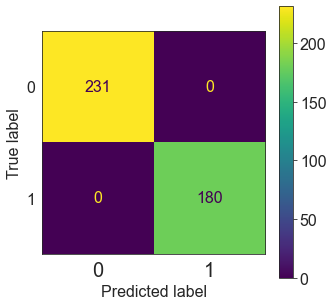

In [148]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.rcParams.update({'font.size': 16})
metrics.plot_confusion_matrix(classifier_all,X_train,Y_train,ax=ax)
plt.savefig("Decision_tree_train_data_all.png")

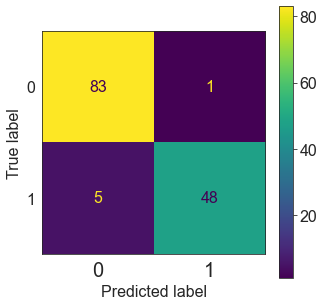

In [149]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.rcParams.update({'font.size': 16})
metrics.plot_confusion_matrix(classifier_all,X_test,Y_test,ax=ax)
plt.savefig("Decision_tree_test_data_all.png")

#### Random Forest

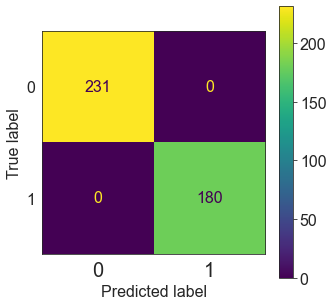

In [150]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.rcParams.update({'font.size': 16})
metrics.plot_confusion_matrix(rf_classifier_all,X_train,Y_train,ax=ax)
plt.savefig("Random_Forest_train_data_all.png")

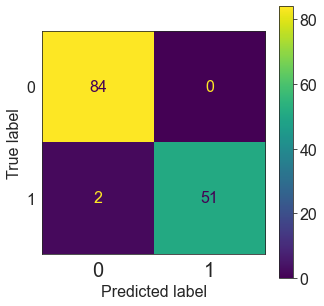

In [151]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.rcParams.update({'font.size': 16})
metrics.plot_confusion_matrix(rf_classifier_all,X_test,Y_test,ax=ax)
plt.savefig("Random_Forest_test_data_all.png")

#### SVM

#### RBF Kernel

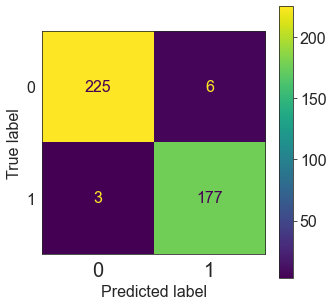

In [152]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.rcParams.update({'font.size': 16})
metrics.plot_confusion_matrix(svclassifier_rbf_all,X_train,Y_train,ax=ax)
plt.savefig("SVM-rbf_kernel_train_data_all.png")

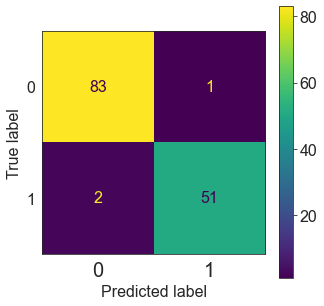

In [153]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.rcParams.update({'font.size': 16})
metrics.plot_confusion_matrix(svclassifier_rbf_all,X_test,Y_test,ax=ax)
plt.savefig("SVM-rbf_kernel_test_data_all.png")

#### Sigmoid Kernel

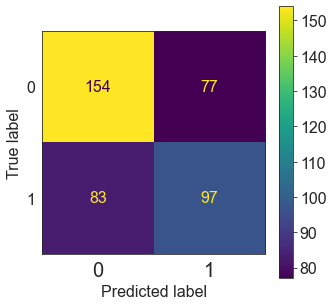

In [154]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.rcParams.update({'font.size': 16})
metrics.plot_confusion_matrix(svclassifier_sig_all,X_train,Y_train,ax=ax)
plt.savefig("SVM-sigmoid_kernel_train_data_all.png")

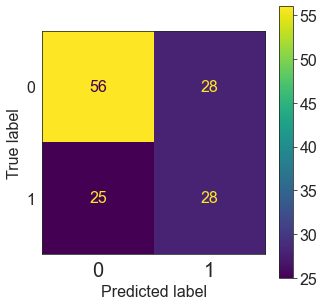

In [155]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.rcParams.update({'font.size': 16})
metrics.plot_confusion_matrix(svclassifier_sig_all,X_test,Y_test,ax=ax)
plt.savefig("SVM-sigmoid_kernel_test_data_all.png")

#### Polynomial kernel

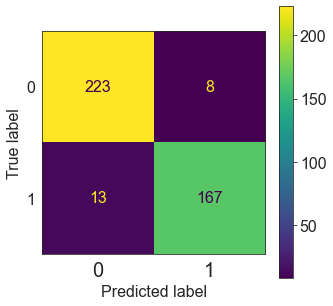

In [156]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.rcParams.update({'font.size': 16})
metrics.plot_confusion_matrix(svclassifier_poly_all,X_train,Y_train,ax=ax)
plt.savefig("SVM-poly_kernel_train_data_all.png")

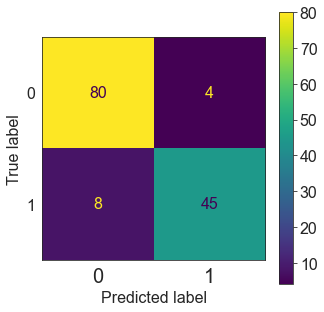

In [157]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.rcParams.update({'font.size': 16})
metrics.plot_confusion_matrix(svclassifier_poly_all,X_test,Y_test,ax=ax)
plt.savefig("SVM-poly_kernel_test_data_all.png")

#### With selected features and no hyperparameters

#### Decision Trees

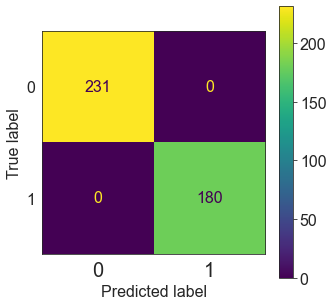

In [158]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.rcParams.update({'font.size': 16})
metrics.plot_confusion_matrix(classifier_sel,X_train_sel,Y_train_sel,ax=ax)
plt.savefig("Decision_Tree_train_data_selected.png")

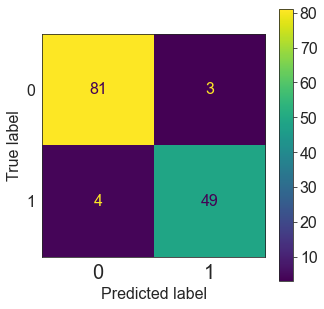

In [159]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.rcParams.update({'font.size': 16})
metrics.plot_confusion_matrix(classifier_sel,X_test_sel,Y_test_sel,ax=ax)
plt.savefig("Decision_Tree_test_data_selected.png")

#### Random Forests

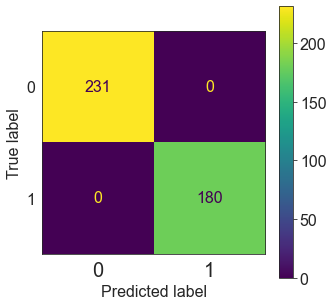

In [160]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.rcParams.update({'font.size': 16})
metrics.plot_confusion_matrix(rf_classifier_selected,X_train_sel,Y_train_sel,ax=ax)
plt.savefig("Random_Forests_train_data_selected.png")

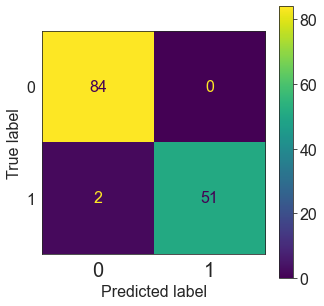

In [161]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.rcParams.update({'font.size': 16})
metrics.plot_confusion_matrix(rf_classifier_selected,X_test_sel,Y_test_sel,ax=ax)
plt.savefig("Random_Forests_test_data_selected.png")

#### SVM

#### RBF Kernel

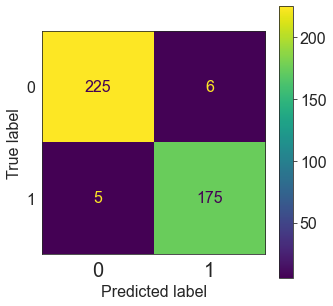

In [162]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.rcParams.update({'font.size': 16})
metrics.plot_confusion_matrix(svclassifier_rbf_sel,X_train_sel,Y_train_sel,ax=ax)
plt.savefig("SVM-rbf_kernel_train_data_selected.png")

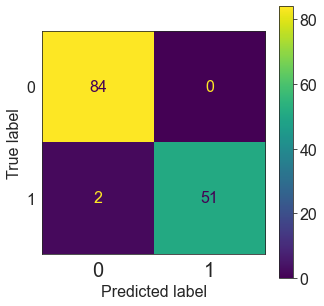

In [163]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.rcParams.update({'font.size': 16})
metrics.plot_confusion_matrix(svclassifier_rbf_sel,X_test_sel,Y_test_sel,ax=ax)
plt.savefig("SVM-rbf_kernel_test_data_selected.png")

#### Sigmoid Kernel

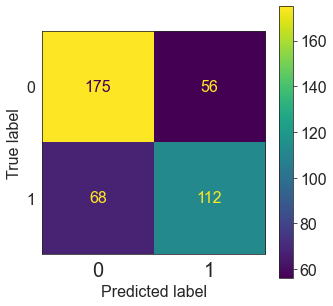

In [164]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.rcParams.update({'font.size': 16})
metrics.plot_confusion_matrix(svclassifier_sig_sel,X_train_sel,Y_train_sel,ax=ax)
plt.savefig("SVM-sigmoid_kernel_train_data_selected.png")

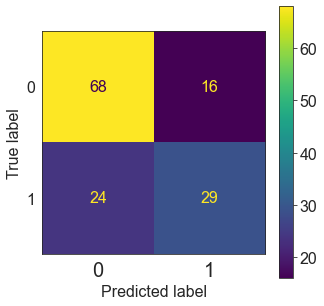

In [165]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.rcParams.update({'font.size': 16})
metrics.plot_confusion_matrix(svclassifier_sig_sel,X_test_sel,Y_test_sel,ax=ax)
plt.savefig("SVM-sigmoid_kernel_test_data_selected.png")

#### Polynomial kernel

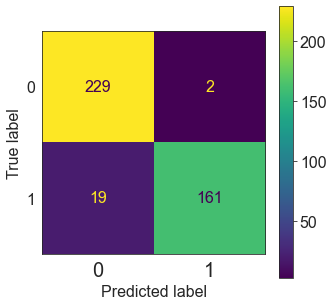

In [166]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.rcParams.update({'font.size': 16})
metrics.plot_confusion_matrix(svclassifier_poly_sel,X_train_sel,Y_train_sel,ax=ax)
plt.savefig("SVM-poly_kernel_train_data_selected.png")

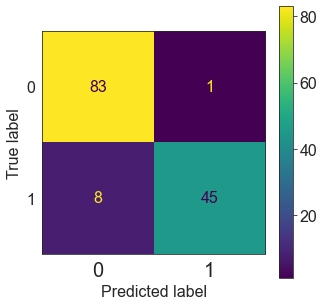

In [168]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.rcParams.update({'font.size': 16})
metrics.plot_confusion_matrix(svclassifier_poly_sel,X_test_sel,Y_test_sel,ax=ax)
plt.savefig("SVM-poly_kernel_test_data_selected.png")

#### With all features and hyperparameters

#### Decision Tree

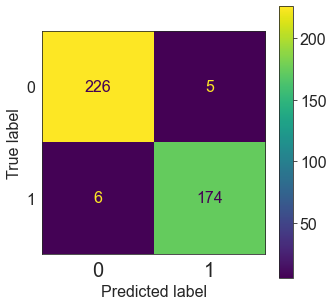

In [169]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.rcParams.update({'font.size': 16})
metrics.plot_confusion_matrix(classifier_hyp_all,X_train,Y_train,ax=ax)
plt.savefig("Decision_tree_with_hyp_train_data_all.png")

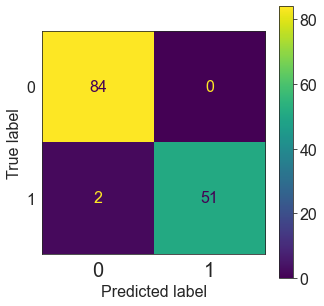

In [170]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.rcParams.update({'font.size': 16})
metrics.plot_confusion_matrix(classifier_hyp_all,X_test,Y_test,ax=ax)
plt.savefig("Decision_tree_with_hyp_test_data_all.png")

#### Random Forest

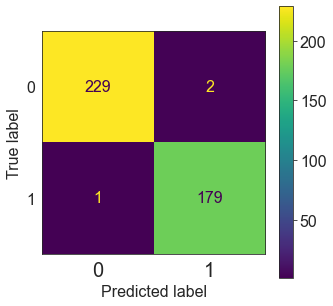

In [171]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.rcParams.update({'font.size': 16})
metrics.plot_confusion_matrix(rf_hyp_classifier_all,X_train,Y_train,ax=ax)
plt.savefig("Random_Forest_with_hyp_train_data_all.png")

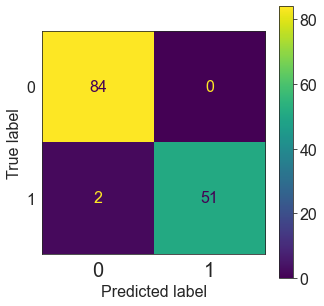

In [172]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.rcParams.update({'font.size': 16})
metrics.plot_confusion_matrix(rf_hyp_classifier_all,X_test,Y_test,ax=ax)
plt.savefig("Random_Forest_with_hyp_test_data_all.png")

#### SVM

#### RBF Kernel

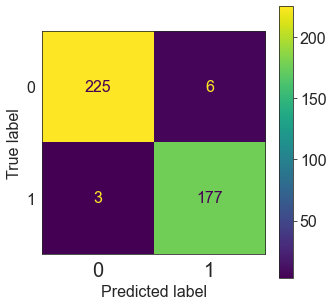

In [173]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.rcParams.update({'font.size': 16})
metrics.plot_confusion_matrix(svclassifier_rbf_hyp_all,X_train,Y_train,ax=ax)
plt.savefig("SVM-rbf_Kernel_with_hyp_train_data_all.png")

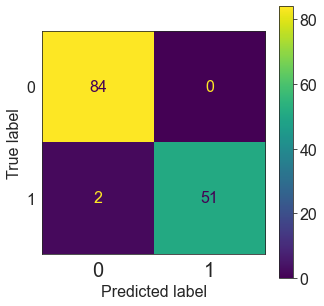

In [174]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.rcParams.update({'font.size': 16})
metrics.plot_confusion_matrix(svclassifier_rbf_hyp_all,X_test,Y_test,ax=ax)
plt.savefig("SVM-rbf_Kernel_with_hyp_test_data_all.png")

#### With selected features and hyperparameters

#### Decision Tree

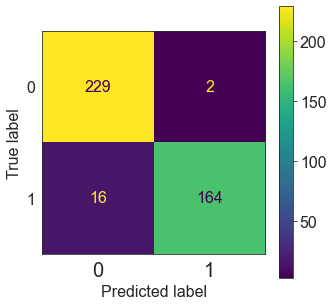

In [175]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.rcParams.update({'font.size': 16})
metrics.plot_confusion_matrix(classifier_hyp_sel,X_train_sel,Y_train_sel,ax=ax)
plt.savefig("Decision_tree_with_hyp_train_data_selected.png")

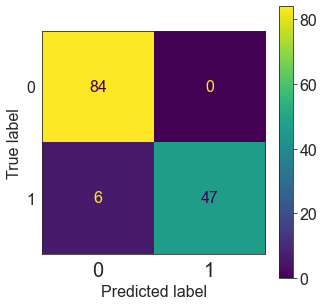

In [176]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.rcParams.update({'font.size': 16})
metrics.plot_confusion_matrix(classifier_hyp_sel,X_test_sel,Y_test_sel,ax=ax)
plt.savefig("Decision_tree_with_hyp_test_data_selected.png")

#### Random Forest

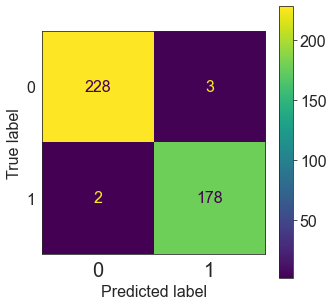

In [177]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.rcParams.update({'font.size': 16})
metrics.plot_confusion_matrix(rf_hyp_classifier_selected,X_train_sel,Y_train_sel,ax=ax)
plt.savefig("Random_Forest_with_hyp_train_data_selected.png")

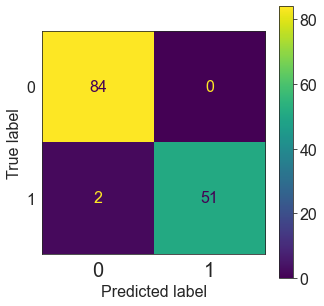

In [178]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.rcParams.update({'font.size': 16})
metrics.plot_confusion_matrix(rf_hyp_classifier_selected,X_test_sel,Y_test_sel,ax=ax)
plt.savefig("Random_Forest_with_hyp_test_data_selected.png")

#### SVM

#### RBF Kernel

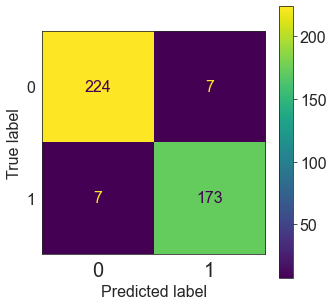

In [179]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.rcParams.update({'font.size': 16})
metrics.plot_confusion_matrix(svclassifier_rbf_hyp_sel,X_train_sel,Y_train_sel,ax=ax)
plt.savefig("SVM-rbf_Kernel_with_hyp_train_data_selected.png")

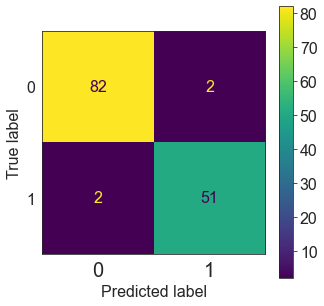

In [180]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.rcParams.update({'font.size': 16})
metrics.plot_confusion_matrix(svclassifier_rbf_hyp_sel,X_test_sel,Y_test_sel,ax=ax)
plt.savefig("SVM-rbf_Kernel_with_hyp_test_data_selected.png")